In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [8]:
from Datacleaning import preprocess_data

file_path = 'housing.csv'
X_train, X_test, y_train, y_test = preprocess_data(file_path)

Features shape: (20640, 12), Target shape: (20640,)


In [9]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14196,1.267645,-1.367976,0.346478,0.224718,0.214986,0.772251,0.322924,-0.321654,False,False,False,True
8267,0.703627,-0.871699,1.617807,0.342065,0.596500,-0.098440,0.670799,-0.030620,False,False,False,True
17445,-0.454356,-0.455012,-1.957806,-0.338639,-0.490815,-0.450778,-0.427755,0.150349,False,False,False,True
14265,1.227714,-1.377340,0.584852,-0.556832,-0.404974,-0.006602,-0.378059,-1.014947,False,False,False,True
2271,-0.114948,0.537543,1.141059,-0.116322,-0.252369,-0.486983,-0.312669,-0.166583,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.803453,-0.867017,0.505394,-0.598545,-0.800795,-0.677723,-0.739013,1.315592,False,False,False,False
11964,1.067992,-0.754652,0.346478,0.205466,0.079072,0.289220,-0.132192,-0.431983,True,False,False,False
5390,0.593818,-0.749970,0.584852,-0.245128,0.076687,0.291870,0.071825,-0.492832,False,False,False,False
860,-1.193070,0.912092,-1.083767,0.430534,0.143452,0.310414,0.155525,0.973025,False,False,False,False


In [10]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (16512, 12)
y_train shape: (16512,)
X_test shape: (4128, 12)
y_test shape: (4128,)


In [11]:
def build_ann_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [12]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    loss, mae = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test MAE: {mae * 1_000_000:.2f}")  

    def plot_history(history):
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.title('Training and Validation MAE')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    plot_history(history)

    return model, history

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7350 - mae: 0.0999 - val_loss: 0.0335 - val_mae: 0.0584 - learning_rate: 0.0010
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0237 - mae: 0.0605 - val_loss: 0.0118 - val_mae: 0.0582 - learning_rate: 0.0010
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0114 - mae: 0.0595 - val_loss: 0.0105 - val_mae: 0.0543 - learning_rate: 0.0010
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104 - mae: 0.0587 - val_loss: 0.0099 - val_mae: 0.0594 - learning_rate: 0.0010
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0100 - mae: 0.0585 - val_loss: 0.0097 - val_mae: 0.0507 - learning_rate: 0.0010
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097 - mae: 0.0571 - val_loss: 0.0093 - val_mae: 0.0520 - learning_rate: 0.0010
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mae: 0.0560 - val_loss: 0.0097 - val_mae: 0.0539 - learning_rate: 0.0010

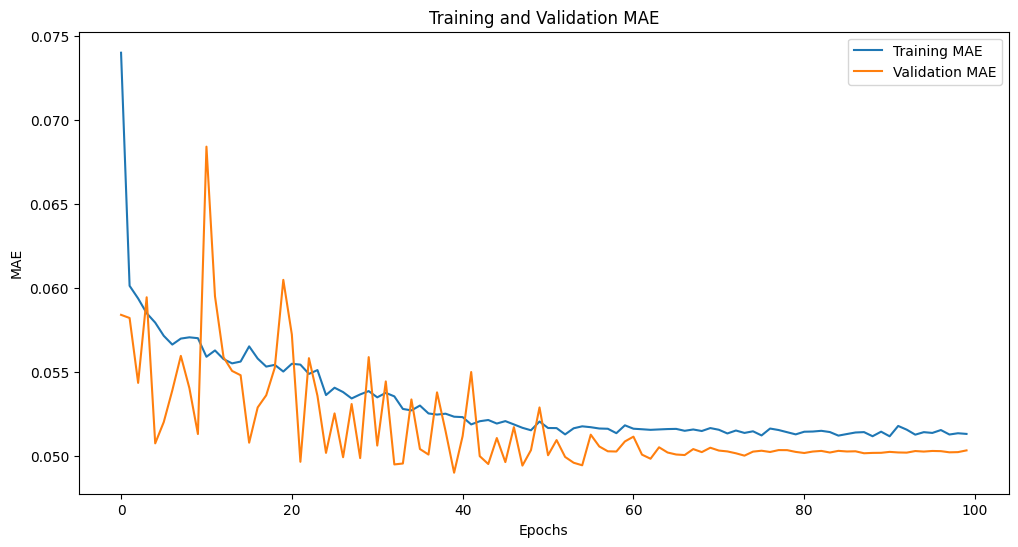

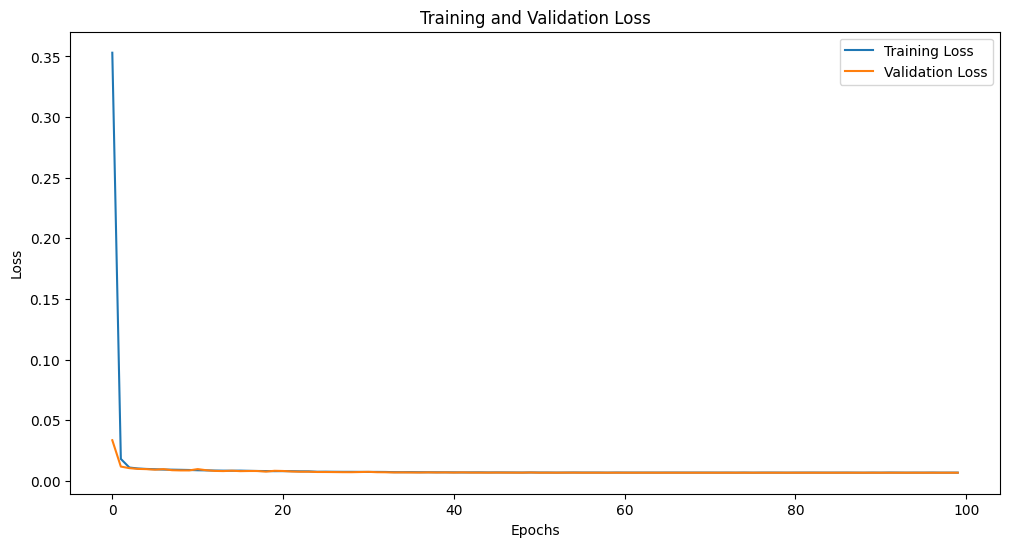

In [13]:
model = build_ann_model(X_train.shape[1])
model, history = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

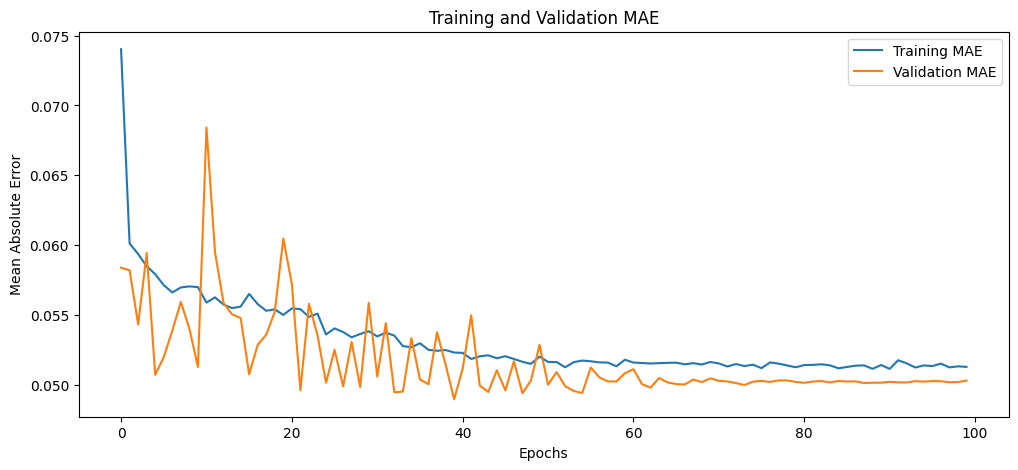

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()